In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/heart_disease_dataset_CHUD_S_A.csv")

print("Total samples:", len(df))
print("Total features:", df.shape[1]-1)
print("\nFirst 5 records:")
display(df.head())
print("\nTotal missing values:", df.isnull().sum().sum())


Total samples: 5000
Total features: 13

First 5 records:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,38.871687,Male,Typical Angina,100.490248,163.166661,NaN,LV hypertrophy,183.658119,No,0.114644,Upsloping,0.0,Normal,no disease
1,60.625755,Male,Asymptomatic,NaN,338.711395,True,LV hypertrophy,141.161921,NaN,2.361526,Downsloping,2.0,NaN,severe
2,64.306898,Male,NaN,146.355656,337.004035,True,LV hypertrophy,NaN,Yes,2.660477,Downsloping,2.0,Reversible defect,severe
3,57.457313,Female,Non-Anginal Pain,NaN,260.116075,True,NaN,150.353969,Yes,1.145959,Flat,1.0,Reversible defect,mild
4,53.394739,Male,Non-Anginal Pain,129.763455,224.948879,False,LV hypertrophy,147.834030,Yes,NaN,Flat,NaN,Reversible defect,mild



Total missing values: 7660


<h2>STEP 2 — Detailed Exploration & Visualization</h2>

In [3]:
print("Instances:", df.shape[0])
print("Features:", df.shape[1]-1)
display(df.dtypes)
display(df.describe())


Instances: 5000
Features: 13


age              float64
sex               object
cp                object
trestbps         float64
chol             float64
fbs               object
restecg           object
thalach          float64
exang             object
oldpeak          float64
slope             object
ca               float64
thal              object
heart_disease     object
dtype: object

,age,trestbps,chol,thalach,oldpeak,ca
count,4411.000000,4399.000000,4425.000000,4416.000000,4407.000000,4411.000000
mean,54.829901,133.019682,262.883223,150.289463,1.778127,1.378372
std,10.855032,19.913154,80.613567,22.141853,1.581597,1.022590
min,29.000000,94.000000,126.000000,101.383435,0.000000,0.000000
25%,46.027138,116.479869,188.967414,131.642083,0.485799,1.000000
50%,54.822873,134.500404,259.801646,149.953070,1.191017,1.000000
75%,63.539473,148.299363,327.875962,169.124221,2.626216,2.000000
max,77.000000,176.782096,423.482009,195.551682,5.165494,3.000000


<h2>Cell 2.2 — Class balance</h2>

In [4]:
class_counts = df['heart_disease'].value_counts()
class_percent = df['heart_disease'].value_counts(normalize=True)*100

balance_df = pd.DataFrame({
    "Count": class_counts,
    "Percentage": class_percent
})

display(balance_df)

imbalance_ratio = class_counts.max() / class_counts.min()
print("Imbalance ratio:", imbalance_ratio)


,Count,Percentage
heart_disease,,
no disease,1030,20.60
mild,1028,20.56
immediate danger,994,19.88
severe,974,19.48
very mild,974,19.48


Imbalance ratio: 1.057494866529774


<h2>Cell 2.3 — Class distribution plot</h2>

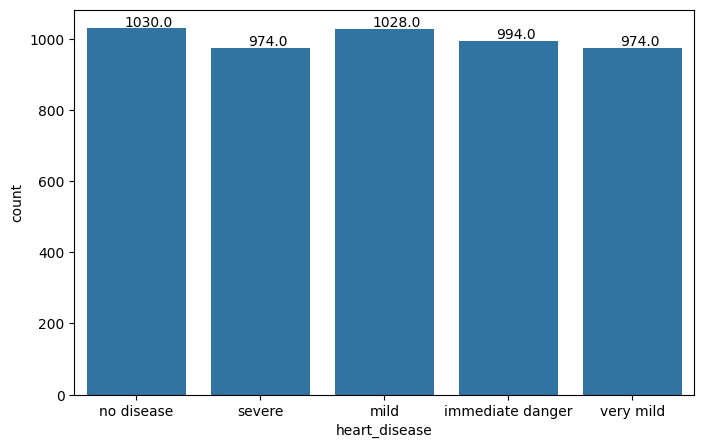

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
ax = sns.countplot(x='heart_disease', data=df)
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+5))
plt.show()


<h2>Cell 2.4 — Correlation heatmap</h2>

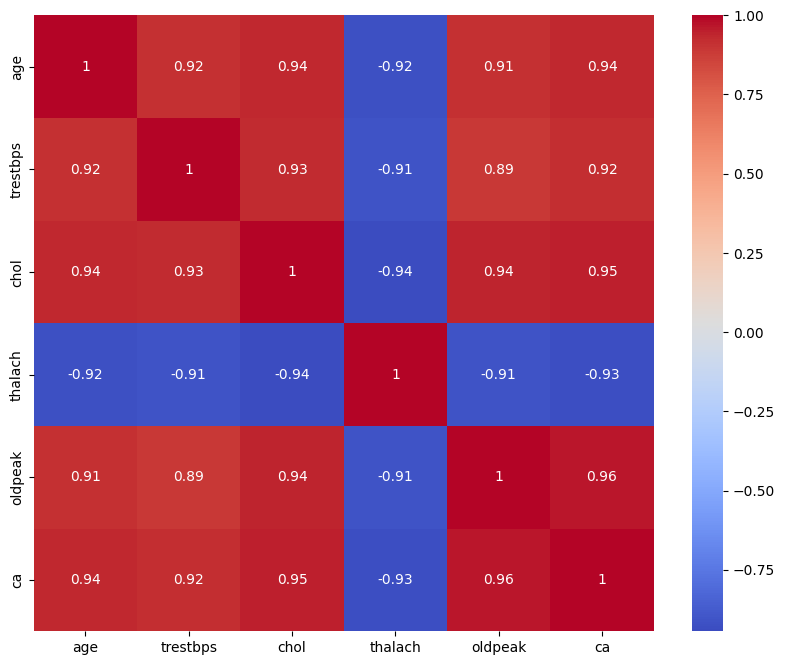

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.show()


<h2>Cell 2.5 — Age boxplot</h2>

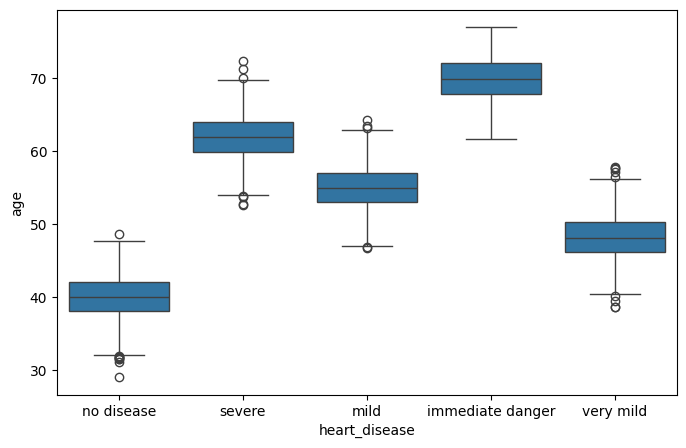

In [7]:
plt.figure(figsize=(8,5))
sns.boxplot(x='heart_disease', y='age', data=df)
plt.show()


<h2>STEP 3 — Preprocessing & Split</h2>

<h3>Cell 3.1 — Split</h3>

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('heart_disease', axis=1)
y = df['heart_disease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Train %:", len(X_train)/len(df)*100)
print("Test %:", len(X_test)/len(df)*100)


Train %: 80.0
Test %: 20.0


<h3>Cell 3.2 — Stratification check
</h3>

In [9]:
dist_df = pd.DataFrame({
    "Original %": y.value_counts(normalize=True)*100,
    "Train %": y_train.value_counts(normalize=True)*100,
    "Test %": y_test.value_counts(normalize=True)*100
})

display(dist_df)


,Original %,Train %,Test %
heart_disease,,,
no disease,20.60,20.600,20.6
mild,20.56,20.575,20.5
immediate danger,19.88,19.875,19.9
severe,19.48,19.475,19.5
very mild,19.48,19.475,19.5


<h3>Cell 3.3 — Identify categorical features</h3>

In [10]:
cat_features = X.select_dtypes(include='object').columns.tolist()
num_features = X.select_dtypes(exclude='object').columns.tolist()

cat_features, num_features


(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'],
 ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca'])

<h2>Cell 3.4 — Preprocessing pipeline</h2>

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features)
])

X_train_t = preprocessor.fit_transform(X_train)
X_test_t = preprocessor.transform(X_test)

X_train_t.shape, X_test_t.shape


((4000, 25), (1000, 25))

<h3>Cell 3.5 — Validate preprocessing</h3>

In [12]:
print("Train missing:", np.isnan(X_train_t).sum())
print("Test missing:", np.isnan(X_test_t).sum())


Train missing: 0
Test missing: 0


<h2>STEP 4 — Model Training & Comparison</h2>

In [13]:
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


In [14]:
models = {
    "RandomForest": (RandomForestClassifier(), {'classifier__n_estimators':[100]}),
    "GradientBoost": (GradientBoostingClassifier(), {'classifier__n_estimators':[100]}),
    "MLP": (MLPClassifier(max_iter=500), {'classifier__hidden_layer_sizes':[(50,)]}),
    "SVM": (SVC(probability=True), {'classifier__C':[1]}),
    "KNN": (KNeighborsClassifier(), {'classifier__n_neighbors':[5]})
}


<h3>Cell 4.3 — Train and record</h3>

In [15]:
results = []

for name,(clf,params) in models.items():
    pipe = Pipeline([('prep', preprocessor), ('classifier', clf)])
    grid = GridSearchCV(pipe, params, cv=3, scoring='accuracy')
    start = time.time()
    grid.fit(X_train, y_train)
    end = time.time()

    results.append({
        "Model": name,
        "Best CV Accuracy": grid.best_score_,
        "Train Accuracy": grid.score(X_train, y_train),
        "Test Accuracy": grid.score(X_test, y_test),
        "Overfitting Gap": grid.score(X_train, y_train) - grid.score(X_test, y_test),
        "Status": "Overfit" if grid.score(X_train,y_train)-grid.score(X_test,y_test)>0.05 else "Good",
        "Time": end-start,
        "Estimator": grid.best_estimator_
    })


In [16]:
results_df = pd.DataFrame(results).drop(columns="Estimator")
display(results_df.sort_values(by="Test Accuracy", ascending=False))


,Model,Best CV Accuracy,Train Accuracy,Test Accuracy,Overfitting Gap,Status,Time
0,RandomForest,0.99900,1.00000,0.999,0.00100,Good,1.287961
1,GradientBoost,0.99900,1.00000,0.999,0.00100,Good,20.301187
2,MLP,0.99750,0.99950,0.997,0.00250,Good,14.107538
3,SVM,0.99825,0.99875,0.997,0.00175,Good,2.154588
4,KNN,0.99100,0.99525,0.989,0.00625,Good,3.154016


<h3>best model</h3>

In [17]:
results_df = pd.DataFrame(results).drop(columns="Estimator")
display(results_df.sort_values(by="Test Accuracy", ascending=False))
# Recreate best_model from results list
best_row = max(results, key=lambda x: x['Test Accuracy'])
best_model = best_row['Estimator']

print("Best model:", best_row['Model'])
print("Test accuracy:", best_row['Test Accuracy'])



,Model,Best CV Accuracy,Train Accuracy,Test Accuracy,Overfitting Gap,Status,Time
0,RandomForest,0.99900,1.00000,0.999,0.00100,Good,1.287961
1,GradientBoost,0.99900,1.00000,0.999,0.00100,Good,20.301187
2,MLP,0.99750,0.99950,0.997,0.00250,Good,14.107538
3,SVM,0.99825,0.99875,0.997,0.00175,Good,2.154588
4,KNN,0.99100,0.99525,0.989,0.00625,Good,3.154016


Best model: RandomForest
Test accuracy: 0.999


<h3>evaluat</h3>

                  precision    recall  f1-score   support

immediate danger       1.00      0.99      1.00       199
            mild       1.00      1.00      1.00       205
      no disease       1.00      1.00      1.00       206
          severe       0.99      1.00      1.00       195
       very mild       1.00      1.00      1.00       195

        accuracy                           1.00      1000
       macro avg       1.00      1.00      1.00      1000
    weighted avg       1.00      1.00      1.00      1000



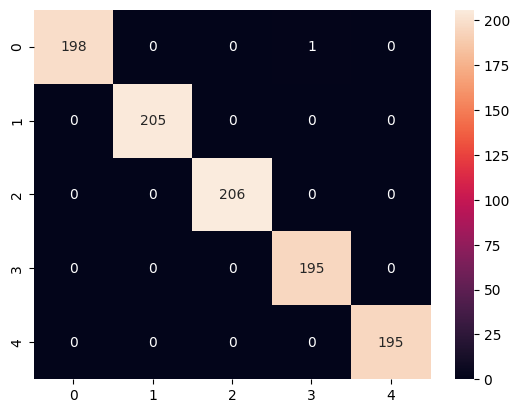

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, best_model.predict(X_test)))
sns.heatmap(confusion_matrix(y_test, best_model.predict(X_test)), annot=True, fmt='d')
plt.show()


In [ ]:
import joblib
import os

# Create deployment folder if it doesn't exist
os.makedirs("deployment", exist_ok=True)

# Save model
joblib.dump(best_model, "deployment/best_heart_model.pkl")

# Save feature column order
with open("deployment/feature_columns.txt", "w") as f:
    for col in X_train.columns:
        f.write(col + "\n")

# Save class names
with open("deployment/class_names.txt", "w") as f:
    for cls in best_model.classes_:
        f.write(str(cls) + "\n")

print(" Model and metadata saved in /deployment folder")


✅ Model and metadata saved in /deployment folder


<h2>STEP 5 — Save Model & Verification</h2>

                  precision    recall  f1-score   support

immediate danger       1.00      0.99      1.00       199
            mild       1.00      1.00      1.00       205
      no disease       1.00      1.00      1.00       206
          severe       0.99      1.00      1.00       195
       very mild       1.00      1.00      1.00       195

        accuracy                           1.00      1000
       macro avg       1.00      1.00      1.00      1000
    weighted avg       1.00      1.00      1.00      1000



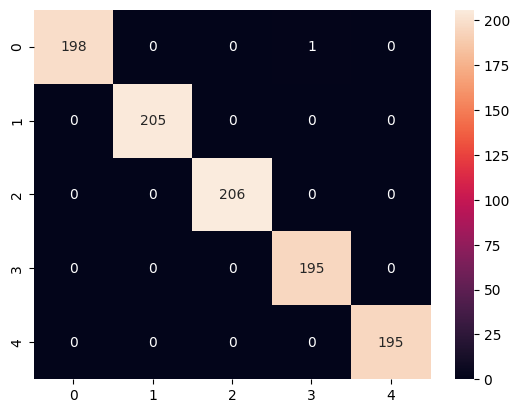

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, best_model.predict(X_test)))
sns.heatmap(confusion_matrix(y_test, best_model.predict(X_test)), annot=True, fmt='d')
plt.show()


<h3>5.1 — Save</h3>

In [21]:
import joblib, os

os.makedirs("deployment", exist_ok=True)

joblib.dump(best_model, "deployment/best_model.pkl")
pd.Series(X.columns).to_csv("deployment/feature_columns.txt", index=False)
pd.Series(best_model.classes_).to_csv("deployment/class_names.txt", index=False)


<h3>verification</h3>

In [22]:
loaded = joblib.load("deployment/best_model.pkl")
sample = X_test.sample(5)
pd.DataFrame({
    "Actual": y_test.loc[sample.index],
    "Predicted": loaded.predict(sample)
})


,Actual,Predicted
2613,mild,mild
2591,very mild,very mild
2859,mild,mild
2231,no disease,no disease
4310,mild,mild


<h3>verification 2</h3>

In [23]:
new_patient = X.sample(1)
probs = loaded.predict_proba(new_patient)[0]

pd.DataFrame({
    "Class": loaded.classes_,
    "Probability": probs
})


,Class,Probability
0,immediate danger,0.0
1,mild,1.0
2,no disease,0.0
3,severe,0.0
4,very mild,0.0
